# Rotterdam stylized case

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
#import pickle
import csv

# IMPORT MODEL CLASSES
from classes import *

from collections import OrderedDict

### Load some existing time series

In [2]:
allSurgeSeries = []

SurgeSeries_A = SurgeSeries(allSurgeSeries,"A",'Scenario A: lower part of RCP4.5',None,None) #Je kunt allSurgeSeries ook gewoon bijhouden in de classes.py
SurgeSeries_B = SurgeSeries(allSurgeSeries,"B",'Scenario B: middle of RCP4.5',None,None)
SurgeSeries_C = SurgeSeries(allSurgeSeries,"C",'Scenario C: middle of RCP8.5',None,None)
SurgeSeries_D = SurgeSeries(allSurgeSeries,"D",'Scenario D: upper part of RCP8.5',None,None)
SurgeSeries_A.from_csv("A.csv")
SurgeSeries_B.from_csv("B.csv")
SurgeSeries_C.from_csv("C.csv")
SurgeSeries_D.from_csv("D.csv")

# Build the actual city

In [3]:
#Create Flood Protection objects
#Maeslantkering = FloodProtection("Maeslantkering",5,True)
Dike = FloodProtection("Sea Dike",4.5,False)
No = FloodProtection("No flood protection",4,False) # Assume 3 meter is the natural elevation of the Heijplaat

#Create ResidentialAreas
Area_A = ResidentialArea("Residential area A: the Heijplaat",4,["No flood protection"])
Area_B = ResidentialArea("Residential area B: city centre",1,["Sea Dike"])

#Create Major
Berry = Major("Berry Kroket")

#### Set parameters

In [4]:
alarming_conditions2 = OrderedDict({ #water depth respective to flood protection level, Name of event, reduction of trust if this happens.
    2   : ['Major flood',40], 
    1   : ['Small flood',20],
    0   : ['Near miss',5],
    -0.5  : ['Major wake-up',3],
    -1  : ['Minor wake-up',2],
    -10  : ['Nothing happens',0]
 })

measures = OrderedDict({ #key, name of measure,additional height, implementation time (years), million euro
    0 : ['Small dike heightening',1,5,10],
    1 : ['Large dike heighteing',3,10,50]
})

# Run the model over time (without adaptation)

In [11]:
#ADD THE INFORMATION OF THE FLOOD PROTECTION STRUCTURES TO THE AREAS IT PROTECTS
for A in allResidentialArea:
    A.match_with_FloodProtection()

#SELECT THE STORM SURGE SERIES FOR WHICH YOU WANT TO RUN

time = allSurgeSeries[0].years

for Area in allResidentialArea:
    Area.trust_t = OrderedDict() #TO TRACK THE DEVELOPMENT OF TRUST
    Area.trust_t[0] = Area.trust_0
    Area.event_impact_history = OrderedDict() #TO SAVE VALUES OF THE 'ALARMING CONDITIONS'
    Area.flood_history = OrderedDict() #TO SAVE FLOOD DEPTHS PER YEAR [IN M]
    for SurgeSeries in allSurgeSeries: #STORE THE RESULTS PER NAME OF THE STORM SURGE SERIES AS KEYS IN ORDERED DICT
        Area.trust_t[SurgeSeries.name] = [None] * len(time)
        Area.trust_t[SurgeSeries.name][0] = Area.trust_0
        Area.event_impact_history[SurgeSeries.name] = [None] * len(time) #TO SAVE VALUES OF THE 'ALARMING CONDITIONS'
        Area.flood_history[SurgeSeries.name] = [None] * len(time) #TO SAVE FLOOD DEPTHS PER YEAR [IN M]

for SurgeSeries in allSurgeSeries:
    # THE MODEL RUNS OVER A YEARLY TIMESTEP
    for i,t in enumerate(time): #Iterate over the years t, with index i
        #print(i,t)

        for Area in allResidentialArea:
            #FIRST EVALUATE IF THE FLOOD PROTECTION LEVEL IS EXCEEDED (TO DETERMINE IF FLOOD HAPPENS)
            if Area.protection_level < SurgeSeries.surgelevel[i]: #if a flood occurs
                Area.flood_history[SurgeSeries.name][i] = SurgeSeries.surgelevel[i] - Area.elevation
                #print("{} is inundated with a water depth of {} m \n --> damage occurs".format(Area.name,Area.flood_history[i]))

            #THEN EVALUATE THE IMPACT ON TRUST
            if i != 0: #don't evaluate trust in the first timestep!
                #print(Area.protection_level-levels_t[i])
                Area.event_impact_history[SurgeSeries.name][i] = evaluate_event(SurgeSeries.surgelevel[i]-Area.protection_level,alarming_conditions2,False)
                #First evaluate the impact of this year's event (if any)
                if Area.event_impact_history[SurgeSeries.name][i] != 0:             #If something happens due to an event:
                    Area.trust_t[SurgeSeries.name][i] = Area.trust_t[SurgeSeries.name][i-1] - Area.event_impact_history[SurgeSeries.name][i]

                else:                             #If nothing happens the trust recovers exponentially
                    k = 0.4 
                    T_eq = 70
                    dTdt = (Area.trust_t[SurgeSeries.name][i-1]-T_eq)*-k
                    Area.trust_t[SurgeSeries.name][i] = Area.trust_t[SurgeSeries.name][i-1] + dTdt

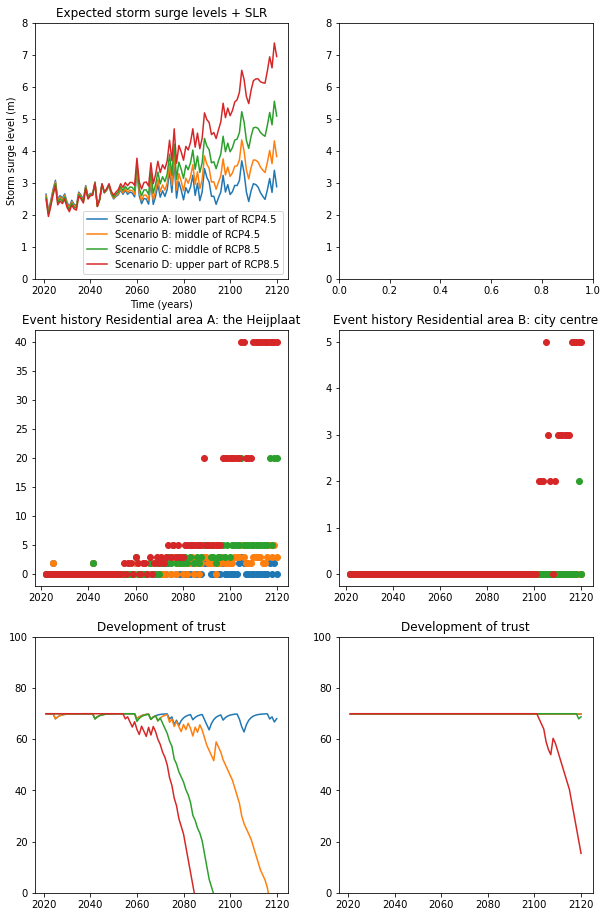

In [12]:
fig, axes = plt.subplots(nrows=3,ncols=2,sharey=False,figsize=(10,16))

labels = []

for SurgeSeries in allSurgeSeries:
    axes[0,0].plot(SurgeSeries.years,SurgeSeries.surgelevel)

    labels.append(SurgeSeries.description)
    axes[0,0].set_title('Expected storm surge levels + SLR')
    axes[0,0].set_xlabel('Time (years)')
    axes[0,0].set_ylabel('Storm surge level (m)')
    axes[0,0].set_ylim(0,8)
    axes[0,1].set_ylim(0,8)

    for i, Area in enumerate(allResidentialArea):
        axes[1,i].set_title('Event history {}'.format(allResidentialArea[i].name))
        axes[1,i].plot(SurgeSeries.years,allResidentialArea[i].event_impact_history[SurgeSeries.name],'o')

        axes[2,i].set_title('Development of trust')
        axes[2,i].plot(SurgeSeries.years,allResidentialArea[i].trust_t[SurgeSeries.name],)

        axes[2,i].set_ylim(0,100)

    axes[0,0].legend(labels)

# First attempt to implement a major with a certain behaviour
Most simple version: if a flood occurs, the flood protection is upgraded with 1 m

In [8]:
#RESET THE PROTECTION LEVELS BEFORE A NEW RUN
for FloodProtection in allFloodProtection:
    FloodProtection.reset_protection_level()
    
#ADD THE INFORMATION OF THE FLOOD PROTECTION STRUCTURES TO THE AREAS IT PROTECTS
for A in allResidentialArea:
    A.match_with_FloodProtection()

#SELECT THE STORM SURGE SERIES FOR WHICH YOU WANT TO RUN

time = allSurgeSeries[0].years

for Area in allResidentialArea:
    Area.trust_t = OrderedDict() #TO TRACK THE DEVELOPMENT OF TRUST
    Area.trust_t[0] = Area.trust_0
    Area.event_impact_history = OrderedDict() #TO SAVE VALUES OF THE 'ALARMING CONDITIONS'
    Area.flood_history = OrderedDict() #TO SAVE FLOOD DEPTHS PER YEAR [IN M]
    for SurgeSeries in allSurgeSeries: #STORE THE RESULTS PER NAME OF THE STORM SURGE SERIES AS KEYS IN ORDERED DICT
        Area.trust_t[SurgeSeries.name] = [None] * len(time)
        Area.trust_t[SurgeSeries.name][0] = Area.trust_0
        Area.event_impact_history[SurgeSeries.name] = [None] * len(time) #TO SAVE VALUES OF THE 'ALARMING CONDITIONS'
        Area.flood_history[SurgeSeries.name] = [None] * len(time) #TO SAVE FLOOD DEPTHS PER YEAR [IN M]

for SurgeSeries in allSurgeSeries:
    # THE MODEL RUNS OVER A YEARLY TIMESTEP
    for i,t in enumerate(time): #Iterate over the years t, with index i
        #print(i,t)

        for Area in allResidentialArea:
            #FIRST EVALUATE IF THE FLOOD PROTECTION LEVEL IS EXCEEDED (TO DETERMINE IF FLOOD HAPPENS)
            if Area.protection_level < SurgeSeries.surgelevel[i]: #if a flood occurs
                Area.flood_history[SurgeSeries.name][i] = SurgeSeries.surgelevel[i] - Area.elevation
                #print("{} is inundated with a water depth of {} m \n --> damage occurs".format(Area.name,Area.flood_history[i]))

            #THEN EVALUATE THE IMPACT ON TRUST
            if i != 0: #don't evaluate trust in the first timestep!
                #print(Area.protection_level-levels_t[i])
                Area.event_impact_history[SurgeSeries.name][i] = evaluate_event(SurgeSeries.surgelevel[i]-Area.protection_level,alarming_conditions2,False)
                #First evaluate the impact of this year's event (if any)
                if Area.event_impact_history[SurgeSeries.name][i] != 0:             #If something happens due to an event:
                    Area.trust_t[SurgeSeries.name][i] = Area.trust_t[SurgeSeries.name][i-1] - Area.event_impact_history[SurgeSeries.name][i]

                else:                             #If nothing happens the trust recovers exponentially
                    k = 0.4 
                    T_eq = 70
                    dTdt = (Area.trust_t[SurgeSeries.name][i-1]-T_eq)*-k
                    Area.trust_t[SurgeSeries.name][i] = Area.trust_t[SurgeSeries.name][i-1] + dTdt
            
        #IMPLEMENT FLOOD PROTECTION MEASURES
        if allResidentialArea[1].event_impact_history['D'][i] == 20:
            print("Update necessary in year {}".format(i))
            Dike.update_protection_level(1)
            for A in allResidentialArea:
                A.match_with_FloodProtection()

Update necessary in year 81
Update necessary in year 84


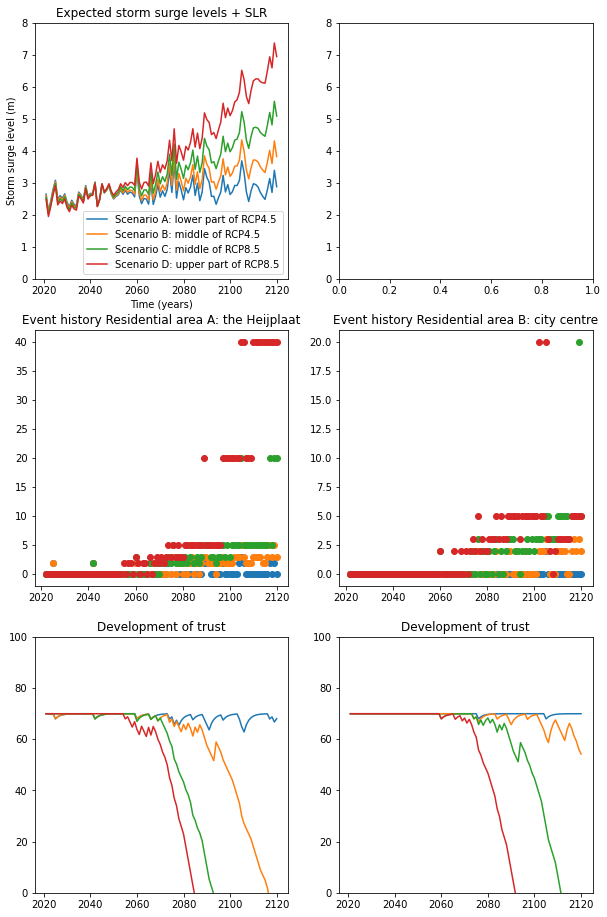

In [9]:
fig, axes = plt.subplots(nrows=3,ncols=2,sharey=False,figsize=(10,16))

labels = []

for SurgeSeries in allSurgeSeries:
    axes[0,0].plot(SurgeSeries.years,SurgeSeries.surgelevel)

    labels.append(SurgeSeries.description)
    axes[0,0].set_title('Expected storm surge levels + SLR')
    axes[0,0].set_xlabel('Time (years)')
    axes[0,0].set_ylabel('Storm surge level (m)')
    axes[0,0].set_ylim(0,8)
    axes[0,1].set_ylim(0,8)

    for i, Area in enumerate(allResidentialArea):
        axes[1,i].set_title('Event history {}'.format(allResidentialArea[i].name))
        axes[1,i].plot(SurgeSeries.years,allResidentialArea[i].event_impact_history[SurgeSeries.name],'o')

        axes[2,i].set_title('Development of trust')
        axes[2,i].plot(SurgeSeries.years,allResidentialArea[i].trust_t[SurgeSeries.name],)

        axes[2,i].set_ylim(0,100)

    axes[0,0].legend(labels)